<a href="https://colab.research.google.com/github/koysean/plotting_workshop/blob/main/Plotting_workshop_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import numpy.polynomial.polynomial as poly
from scipy.optimize import curve_fit

First import data from github

In [ ]:
!wget https://raw.githubusercontent.com/koysean/plotting_workshop/main/c_e_v.csv
!wget https://raw.githubusercontent.com/koysean/plotting_workshop/main/si_e_v.csv
!wget https://raw.githubusercontent.com/koysean/plotting_workshop/main/ge_e_v.csv

Then parse the CSV files into numpy arrays. With this code the data will be arranged into 2 x *n* arrays, with the first row containing volumes (Å<sup>3</sup>) and the second row containing energy (eV).

*Note: raw energy values should not be directly compared as they do not share a well-defined reference point*

In [ ]:
c_e_v = [[], []]
si_e_v = [[], []]
ge_e_v = [[], []]

with open('c_e_v.csv', 'r') as file:
  for line in file.readlines():
    split_line = line.split(',')
    c_e_v[0].append(float(split_line[0]))
    c_e_v[1].append(float(split_line[1]))
  c_e_v = np.asarray(c_e_v)

with open('si_e_v.csv', 'r') as file:
  for line in file.readlines():
    split_line = line.split(',')
    si_e_v[0].append(float(split_line[0]))
    si_e_v[1].append(float(split_line[1]))
  si_e_v = np.asarray(si_e_v)

with open('ge_e_v.csv', 'r') as file:
  for line in file.readlines():
    split_line = line.split(',')
    ge_e_v[0].append(float(split_line[0]))
    ge_e_v[1].append(float(split_line[1]))
  
  ge_e_v = np.asarray(ge_e_v)

We can find the equilibrium volume and energy by looking at where the energy is at a minimum.

In [ ]:
min_volumes = {
    'c':  c_e_v[0][np.argmin(c_e_v[1])],
    'si':  si_e_v[0][np.argmin(si_e_v[1])],
    'ge':  ge_e_v[0][np.argmin(ge_e_v[1])]
}

min_energies = {
    'c':  np.min(c_e_v[1]),
    'si':  np.min(si_e_v[1]),
    'ge':  np.min(ge_e_v[1])
}

print('(Roughly) Equilibrium values of (V, E):')
print('C:\t{:.3f}, {:.3f}'.format(min_volumes['c'], min_energies['c']))
print('Si:\t{:.3f}, {:.3f}'.format(min_volumes['si'], min_energies['si']))
print('Ge:\t{:.3f}, {:.3f}'.format(min_volumes['ge'], min_energies['ge']))

(Roughly) Equilibrium values of (V, E):
C:	11.345, -18.658
Si:	41.569, -10.856
Ge:	48.035, -9.105


With this data, we can plot the energy-volume curve!

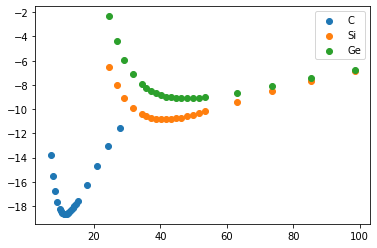

In [89]:
fig, ax = plt.subplots()

sc_c = ax.scatter(c_e_v[0], c_e_v[1])
sc_si = ax.scatter(si_e_v[0], si_e_v[1])
sc_ge = ax.scatter(ge_e_v[0], ge_e_v[1])

ax.legend([sc_c, sc_si, sc_ge], ['C', 'Si', 'Ge'])

We can try a rudimentary second-order polynomial fit to the data, excluding the points where the curves are obviously non-parabolic.

In [ ]:
poly_c = poly.polyfit(c_e_v[0][4:16], c_e_v[1][4:16], 2)
poly_si = poly.polyfit(si_e_v[0][4:16], si_e_v[1][4:16], 2)
poly_ge = poly.polyfit(ge_e_v[0][4:16], ge_e_v[1][4:16], 2)

We can plot these fits along with the real data.

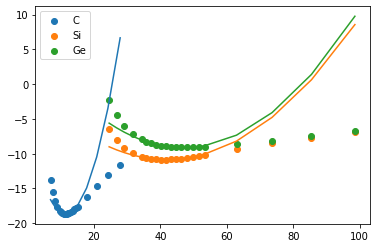

In [107]:
fig, ax = plt.subplots()

sc_c = ax.scatter(c_e_v[0], c_e_v[1])
ax.plot(c_e_v[0], poly.polyval(c_e_v[0], poly_c))

sc_si = ax.scatter(si_e_v[0], si_e_v[1])
ax.plot(si_e_v[0], poly.polyval(si_e_v[0], poly_si))

sc_ge = ax.scatter(ge_e_v[0], ge_e_v[1])
ax.plot(ge_e_v[0], poly.polyval(ge_e_v[0], poly_ge))

ax.legend([sc_c, sc_si, sc_ge], ['C', 'Si', 'Ge'])

Not too good. We can do better and also extract physical parameters from this data by fitting to an equation of state. In this example, we fit to the Birch–Murnaghan equation of state:

$E(V) = E_0 + \dfrac{9V_0B_0}{16} \left\{ \left[   \left(  \dfrac{V_0}{V}\right)^{\frac{2}{3}} - 1 \right]^3 B_0'  + \left[  \left(  \dfrac{V_0}{V}\right)^{\frac{2}{3}}-1 \right]^2 \left[ 6 - 4 \left(  \dfrac{V_0}{V}\right)^{\frac{2}{3}}    \right]    \right\}$

In [69]:
def bm_eos(v, v0, b0, bp0, e0):
  ''' Birch-Murnaghan EOS. 
  Arguments:
    v: volume input
    v0: equilibrium volume
    b0: bulk modulus at equilibrium
    bp0: derivative of bulk modulus wrt pressure at equilibrium
    e0: equilibrium energy
  
  Outputs:
     Internal energy of the system, E(V)
  '''

  gamma = (v0/v)**(2/3)

  return e0 + 9/16 * v0 * b0 * (
      (gamma - 1)**3 * bp0
      + (gamma - 1)**2 * (6 - 4*gamma)
  )

Using scipy's optimize library, we can fit our data to the B-M equation of state. The fit coefficients are given in the order of the parameters as defined in the function above, i.e. (v0, b0, bp0, e0):

In [92]:
fit_c, conv_c = curve_fit(bm_eos, c_e_v[0], c_e_v[1], p0 = [min_volumes['c'], 2, 2, -10])

fit_si, conv_si = curve_fit(bm_eos, si_e_v[0], si_e_v[1], p0 = [min_volumes['si'], 2, 2, -10])

fit_ge, conv_ge = curve_fit(bm_eos, ge_e_v[0], ge_e_v[1], p0 = [min_volumes['ge'], 2, 2, -10])

print('Fit parameters for C:', fit_c)

Fit parameters for C: [ 11.31433243   2.69028099   3.91315318 -18.64456242]


Again, plotting against the real data:

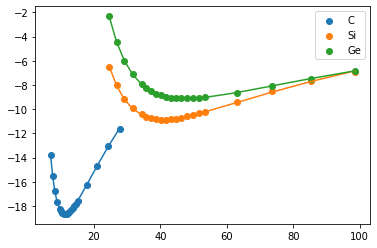

In [106]:
fig, ax = plt.subplots()

sc_c = ax.scatter(c_e_v[0], c_e_v[1])
ax.plot(c_e_v[0], bm_eos(c_e_v[0], *fit_c))

sc_si = ax.scatter(si_e_v[0], si_e_v[1])
ax.plot(si_e_v[0], bm_eos(si_e_v[0], *fit_si))

sc_ge = ax.scatter(ge_e_v[0], ge_e_v[1])
ax.plot(ge_e_v[0], bm_eos(ge_e_v[0], *fit_ge))

ax.legend([sc_c, sc_si, sc_ge], ['C', 'Si', 'Ge'])

And it returns a pretty good fit!

So far we've just created the most basic plots we can with this data and the fits. See if you can make these plots any nicer! Think about what you can communicate with this data and then try to make a clear and `a e s t h e t i c` plot.

Remember, the data you have to work with for each material (C, Si, Ge) is:

*   Raw DFT energy-volume data
*   The Birch-Murnaghan equation of state and its fitted parameters, including bulk modulus
*   The quadratic fitting coefficients


---



Some questions to get you thinking about what or how to make a good plot from this data:

*   What are the quantities of interest?
*   What do the fits show that the raw data doesn't?
*   What do you want your audience to learn from your plot?
*   How can you minimize the amount of thinking required on behalf of your audience in interpreting your plot; in other words, how can you make your plot efficient?

Once you have a visualization, ask yourself those questions again to see if you can find further ways to improve your plot. Here are a few more questions you can ask yourself:

*   Is the feature or quantity you're trying to communicate the most obvious part of the plot?
*   Are the colors visually distinct? What about to someone with colorblindness (red-green colorblindness is the most common type)?
*   Does understanding your plot require frequent visual lookup (i.e. looking back and forth at the plot and a legend to make sense of the plot)?
